In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import warnings
import math


warnings.filterwarnings('ignore')
%matplotlib inline


In [91]:
df_data = pd.read_csv('./data/encirclement/AW_LPV_lassy.csv')

In [92]:
df_data.describe()

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar
count,2063.000000,2063.000000,2063.000000,2063.000000,2063.000000,2063.000000,2063.000000
mean,61.252545,15695.126515,12.690110,-1.496370,18.845620,1.226369,135.425594
std,35.339132,3422.701803,6.015215,6.775008,8.155905,0.643284,11.585559
min,0.000000,10281.000000,3.254010,-12.881600,4.719330,0.000000,98.000000
25%,31.000000,12201.000000,7.616720,-7.742730,10.472900,1.000000,128.000000
50%,61.000000,15636.000000,11.145400,-2.274370,19.328900,1.000000,135.000000
75%,92.000000,18515.000000,17.659850,4.791815,25.316300,1.000000,145.000000
max,122.000000,21983.000000,24.778000,9.725260,32.630200,3.000000,167.000000


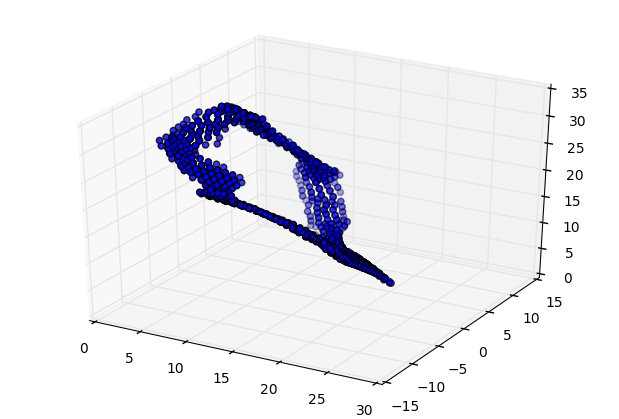

In [93]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df_data['X'], df_data['Y'], df_data['Z'])
plt.show()

In [94]:
df_data_scalars = pd.concat([df_data['MainVertexSeq'], df_data['MeshScalar']], axis=1)

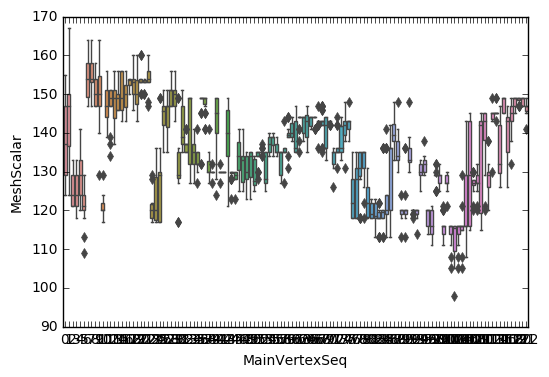

In [95]:
ax = sns.boxplot(x="MainVertexSeq", y="MeshScalar", data=df_data_scalars)

In [96]:
g1 = df_data.groupby(['MainVertexSeq']).median()
g1 = g1.reset_index()

In [97]:
g1.head(2)

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar
0,0,10891.0,14.0719,5.42438,6.64452,1.0,137.0
1,1,10891.0,14.6669,4.77617,6.66704,1.0,147.0


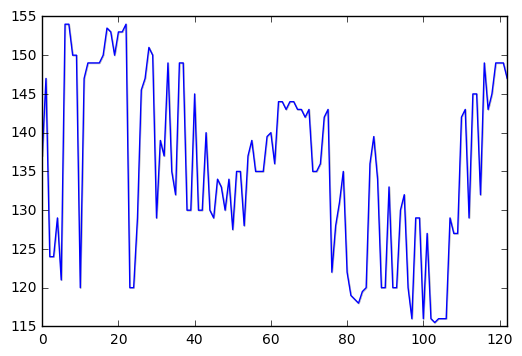

In [98]:
ax = sns.tsplot(data=g1['MeshScalar'])

In [99]:
center_data = [df_data['X'].mean(), df_data['Y'].mean(), df_data['Z'].mean()]

In [100]:
center_data

[12.690109578284039, -1.4963700866214298, 18.84561977217646]

In [101]:
df_data_scalars = pd.concat([df_data['MainVertexSeq'], df_data['MeshScalar']], axis=1)

In [102]:
g1 = df_data.groupby(['MainVertexSeq']).median()
g1 = g1.reset_index()

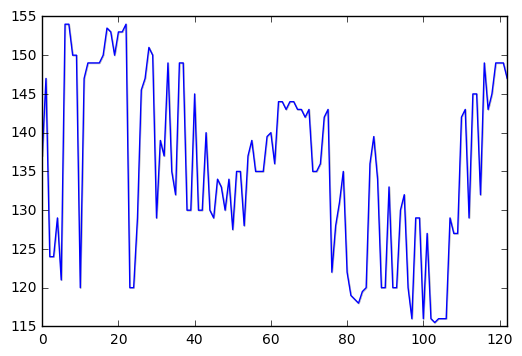

In [103]:
ax = sns.tsplot(data=g1['MeshScalar'])

In [104]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [105]:
def point_theta(center, A):
    thetas = []; 
    Ref_pt = [A.iloc[0]['X'], A.iloc[0]['Y'], A.iloc[0]['Z']] 
    for index, row in A.iterrows():
        pt = [row['X'], row['Y'], row['Z']]
        theta = angle_between(Ref_pt, pt)
        thetas.append(theta)
    return thetas


In [106]:
thetas = point_theta(center_data, df_data)

In [107]:
thetas_df = pd.Series(thetas, name='theta');

In [108]:
df_data_with_theta = pd.concat([df_data, thetas_df], axis=1)

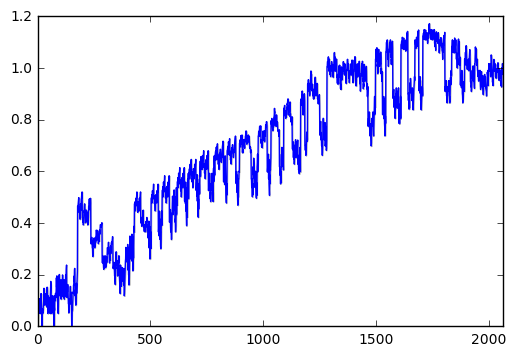

In [109]:
sns.tsplot(df_data_with_theta['theta'])

In [110]:
df_data_with_thetas_sorted = df_data_with_theta.sort_values(by='theta')

In [111]:
df_data_with_thetas_sorted.head(10)

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta
0,0,10891,14.0276,5.47094,6.64452,0,129,0.000000
19,1,10891,14.0276,5.47094,6.64452,2,129,0.000000
151,9,10891,14.0276,5.47094,6.64452,1,129,0.000000
73,4,10891,14.0276,5.47094,6.64452,1,129,0.000000
1,0,10891,14.0276,5.47094,6.64452,3,129,0.000000
63,4,10897,13.3487,6.04894,6.66704,3,129,0.050213
55,3,10897,13.3487,6.04894,6.66704,1,129,0.050213
62,4,10897,13.3487,6.04894,6.66704,0,129,0.050213
23,1,10897,13.3487,6.04894,6.66704,1,129,0.050213
11,0,10897,13.3487,6.04894,6.66704,1,129,0.050213


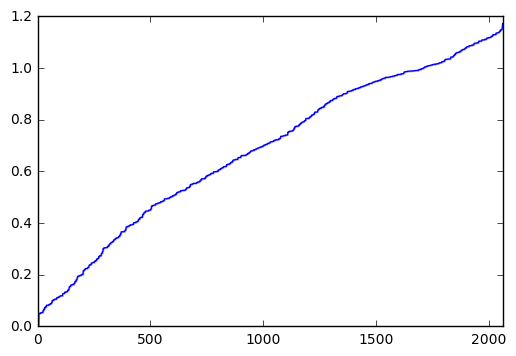

In [112]:
sns.tsplot(df_data_with_thetas_sorted['theta'])

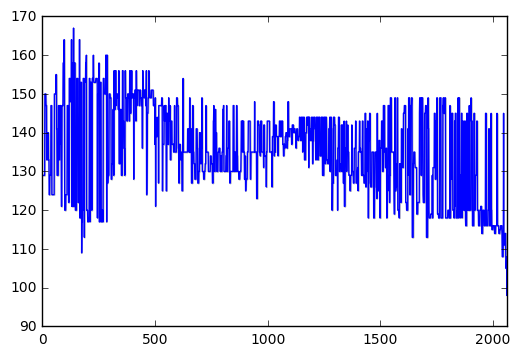

In [113]:
sns.tsplot(df_data_with_thetas_sorted['MeshScalar'])

In [114]:
df_data_with_thetas_sorted.head(15)

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta
0,0,10891,14.0276,5.47094,6.64452,0,129,0.000000
19,1,10891,14.0276,5.47094,6.64452,2,129,0.000000
151,9,10891,14.0276,5.47094,6.64452,1,129,0.000000
73,4,10891,14.0276,5.47094,6.64452,1,129,0.000000
1,0,10891,14.0276,5.47094,6.64452,3,129,0.000000
63,4,10897,13.3487,6.04894,6.66704,3,129,0.050213
55,3,10897,13.3487,6.04894,6.66704,1,129,0.050213
62,4,10897,13.3487,6.04894,6.66704,0,129,0.050213
23,1,10897,13.3487,6.04894,6.66704,1,129,0.050213
11,0,10897,13.3487,6.04894,6.66704,1,129,0.050213


In [115]:
df_data_with_thetas_sorted['MeshScalar'].std()

11.585559271404769

In [116]:
df_data_with_thetas_sorted.head()

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta
0,0,10891,14.0276,5.47094,6.64452,0,129,0.0
19,1,10891,14.0276,5.47094,6.64452,2,129,0.0
151,9,10891,14.0276,5.47094,6.64452,1,129,0.0
73,4,10891,14.0276,5.47094,6.64452,1,129,0.0
1,0,10891,14.0276,5.47094,6.64452,3,129,0.0


In [117]:
df_data_with_thetas_sorted_nodupes = df_data_with_thetas_sorted.drop_duplicates(subset='VertexID', keep='last');

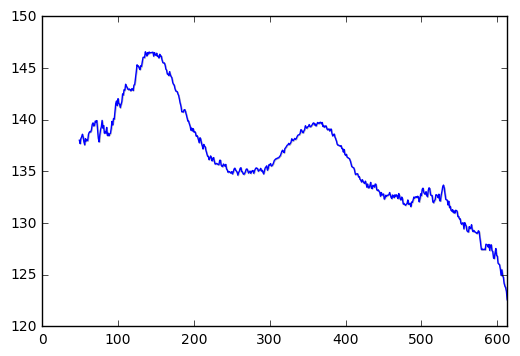

In [118]:
sns.tsplot(pd.rolling_mean(df_data_with_thetas_sorted_nodupes['MeshScalar'],50))

In [119]:
df_data_with_thetas_sorted_nodupes.describe()

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,61.998371,15750.076547,12.553547,-1.346634,18.966125,1.192182,135.664495,0.689588
std,35.542108,3458.513581,6.019440,6.810610,8.241138,0.561579,11.827532,0.303376
min,0.000000,10281.000000,3.254010,-12.881600,4.719330,0.000000,98.000000,0.000000
25%,32.000000,12216.250000,7.539588,-7.706960,10.576650,1.000000,128.000000,0.468842
50%,61.000000,16047.500000,10.993850,-1.688120,19.411600,1.000000,135.000000,0.716772
75%,92.750000,18527.000000,17.593800,4.916430,25.759050,1.000000,145.000000,0.958867
max,122.000000,21983.000000,24.778000,9.725260,32.630200,3.000000,167.000000,1.172375


In [120]:
''' 
This function is not complete yet, it tries to compute the distance between each point in the list to its
point on the line (vertex depth = v for all points within the same neighbourhood) 
'''
def scar_width(df, threshold):
    width = []; 
    is_scar = []; 
    #Ref_pt = [A.iloc[0]['X'], A.iloc[0]['Y'], A.iloc[0]['Z']] 
    
    for index, row in df.iterrows():
        if row['VertexDepth'] == 0:
            pt_on_line = (row['X'], row['Y'], row['Z'])
            
        pt = (row['X'], row['Y'], row['Z'])
        #distance = math.hypot(pt[0]-pt_on_line[0], pt[1]-pt_on_line[1], pt[1]-pt_on_line[1])
        distance = math.sqrt((pt[0]-pt_on_line[0])**2 + (pt[1]-pt_on_line[1])**2 + (pt[2]-pt_on_line[2])**2)
        
        
        if row['MeshScalar'] > threshold: 
            is_scar.append(1) 
            width.append(distance)
        else:
            is_scar.append(0)
            width.append(0)
    
    width_df = pd.Series(width, name='scar_width');
    is_scar_df = pd.Series(is_scar, name='scar_bin');
    
    df = pd.concat([df, width_df], axis=1)
    df = pd.concat([df, is_scar_df], axis=1)

    return df

In [121]:
df_data_with_thetas_sorted = scar_width(df_data_with_thetas_sorted, 135)

In [122]:
df_data_with_thetas_sorted.head(20)

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta,scar_width,scar_bin
0,0,10891,14.0276,5.47094,6.64452,0,129,0.000000,0.000000,0
1,0,10891,14.0276,5.47094,6.64452,3,129,0.000000,0.000000,0
2,0,10577,14.5331,5.06337,6.03235,2,147,0.053935,0.000000,0
3,0,10576,14.0719,5.42438,5.47602,1,133,0.067395,0.000000,0
4,0,10281,14.7414,5.03519,5.14864,1,147,0.104296,0.000000,0
5,0,10578,15.1273,4.59701,5.92603,1,155,0.091151,0.000000,0
6,0,10892,14.6669,4.77617,6.89592,1,150,0.052362,0.000000,0
7,0,10584,13.4095,5.83217,5.75099,2,133,0.054098,0.000000,0
8,0,10288,12.6758,6.10886,4.95868,1,133,0.105097,0.000000,0
9,0,10289,13.4681,5.74157,4.71933,1,137,0.107763,0.000000,0


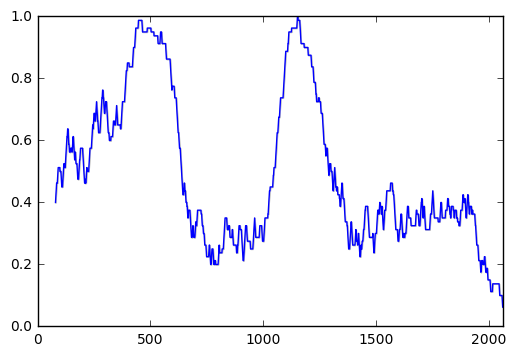

In [123]:
sns.tsplot(pd.rolling_mean(df_data_with_thetas_sorted['scar_bin'],80))

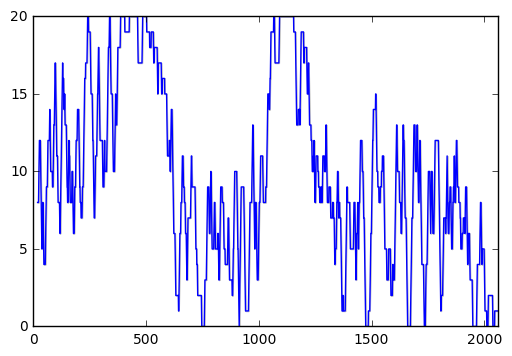

In [130]:
sns.tsplot(pd.rolling_sum(df_data_with_thetas_sorted['scar_bin'],20))

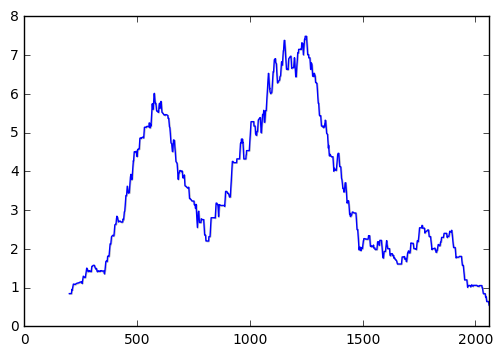

In [125]:
sns.tsplot(pd.rolling_mean(df_data_with_thetas_sorted['scar_width'],200)) # Uses mean windowing=100, so 0 widths are smoothed